In [1]:
import warnings 

import geopandas as gpd
import libpysal
import mapclassify
import matplotlib.pyplot as plt
import momepy as mm
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

from tqdm.auto import tqdm
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy
from clustergram import Clustergram
from bokeh.plotting import show

# we are using bleeding edge software that emits some warnings irrelevant for the current runtime
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
warnings.filterwarnings('ignore', message='.*overflow encountered*')
warnings.filterwarnings('ignore', message='.*index_parts defaults to True')
warnings.filterwarnings('ignore', message='.*`op` parameter is deprecated*')

In [2]:
local_crs = 2154

### Buildings

In [3]:
# load data
buildings = gpd.read_parquet('./data/buildings.parquet')

In [4]:
# clean buildings
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)
buildings = buildings[["geometry"]].to_crs(local_crs)
buildings["uID"] = range(len(buildings))

<AxesSubplot:>

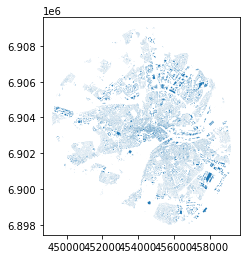

In [5]:
buildings.plot()

### Streets

In [6]:
streets = gpd.read_parquet('./data/streets.parquet')

### Tessellation

In [7]:
limit = mm.buffered_limit(buildings, 100)

tessellation = mm.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
tessellation = tessellation.tessellation

c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\momepy\elements.py:383: UserWarning: Tessellation does not fully match buildings. 296 element(s) collapsed during generation - unique_id: {47112, 20489, 26636, 30737, 8214, 24602, 2087, 47153, 4176, 18513, 6236, 51308, 4213, 51317, 10367, 51328, 39045, 18573, 4248, 4282, 8387, 24781, 28899, 39141, 39146, 39147, 8429, 39149, 39165, 39167, 6407, 8457, 24847, 22807, 39191, 28966, 16707, 39242, 39244, 39247, 39250, 4435, 6491, 8539, 35165, 20835, 22892, 20845, 10612, 16771, 51597, 27026, 6553, 8601, 39330, 39331, 39332, 39333, 39334, 39335, 4528, 6594, 22998, 18904, 2522, 6626, 8674, 18923, 8699, 8713, 39437, 47635, 8731, 8735, 23098, 6722, 16978, 35420, 35423, 8800, 51810, 8812, 6772, 6776, 19068, 19072, 17050, 21168, 17075, 8890, 8894, 17091, 27347, 25303, 728, 19164, 8933, 6894, 8943, 13040, 8963, 21255, 49939, 49944, 19229, 6947, 17187, 19256, 21307, 43835, 836, 43858, 17255, 43886, 43889, 43890, 43891, 4982, 9079, 23414, 21384

### Link streets


In [8]:
buildings = buildings.sjoin_nearest(streets, max_distance=1000, how="left")

In [9]:
buildings = buildings.drop_duplicates("uID").drop(columns="index_right")

In [10]:
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

### Measure
#### Dimensions

In [11]:
buildings["area"] = buildings.area
tessellation["area"] = tessellation.area
streets["length"] = streets.length

#### Shape

In [12]:
buildings['eri'] = mm.EquivalentRectangularIndex(buildings).series
buildings['elongation'] = mm.Elongation(buildings).series
tessellation['convexity'] = mm.Convexity(tessellation).series
streets["linearity"] = mm.Linearity(streets).series

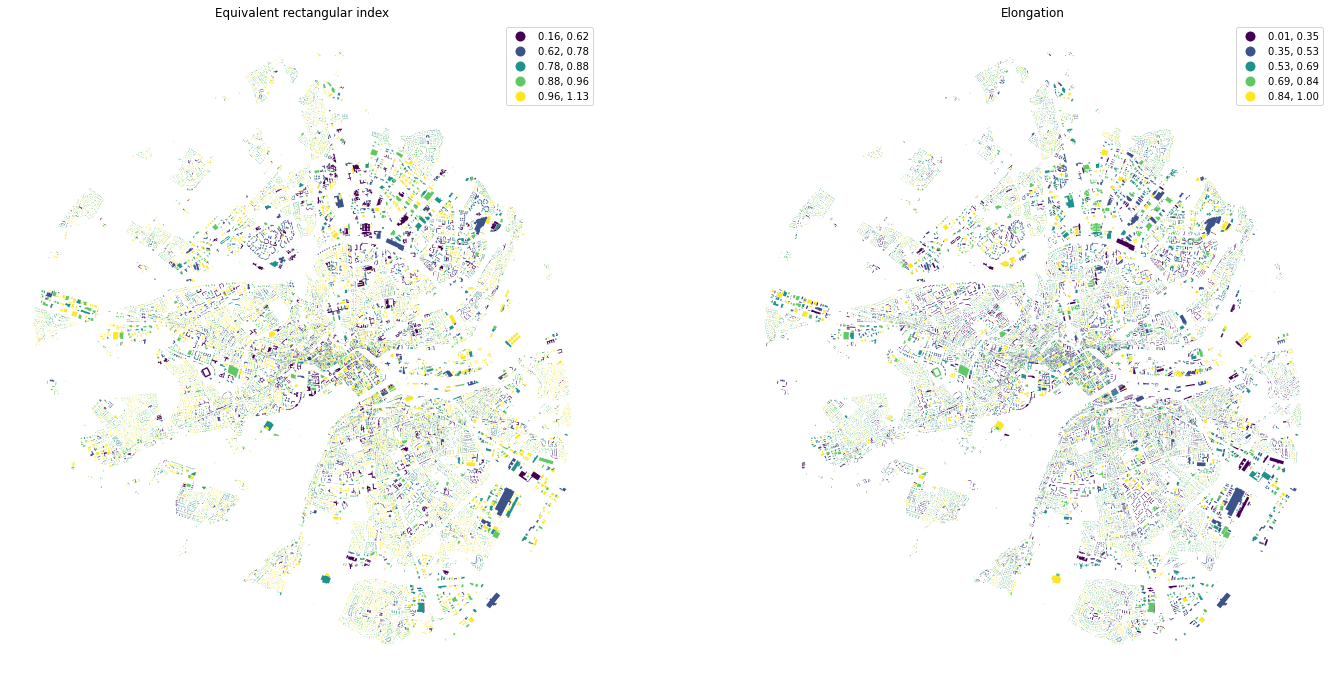

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

ax[0].title.set_text('Equivalent rectangular index')
ax[1].title.set_text('Elongation')

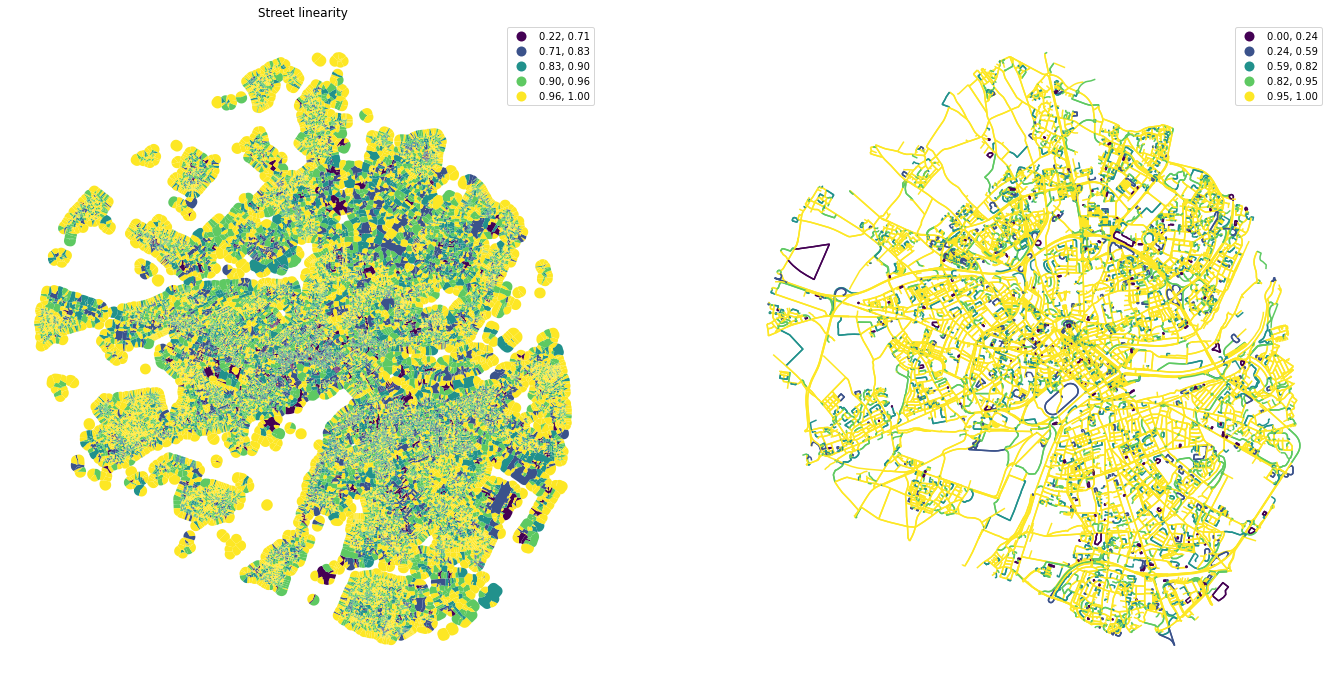

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

ax[0].title.set_text('Convexity')
ax[0].title.set_text('Street linearity')

#### Spatial distribution

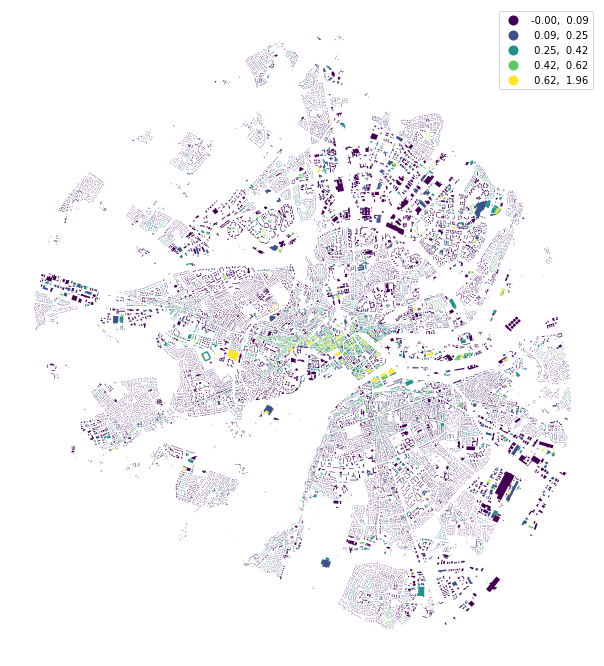

In [15]:
buildings["shared_walls"] = mm.SharedWallsRatio(buildings).series
buildings.plot("shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True).set_axis_off()

In [16]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

In [17]:
tessellation["neighbors"] = mm.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["covered_area"] = mm.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    buildings["neighbor_distance"] = mm.NeighborDistance(buildings, queen_1, "uID", verbose=False).series

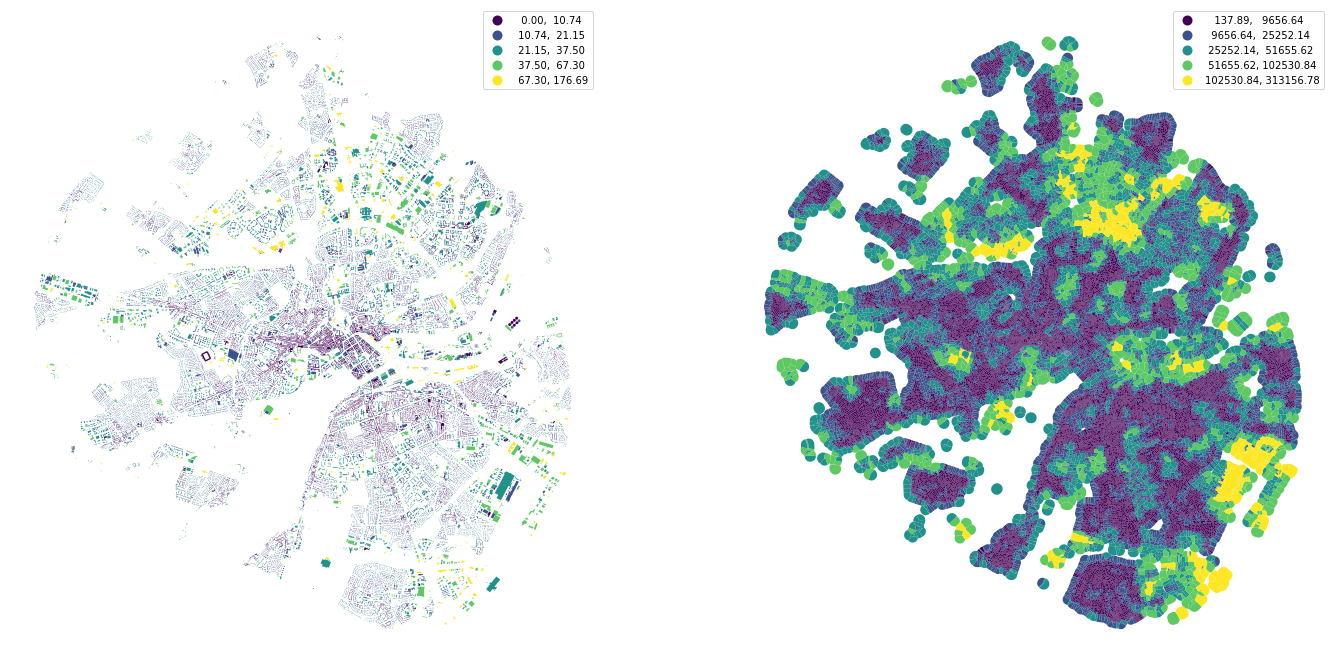

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True)
tessellation.plot("covered_area", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [19]:
queen_3 = mm.sw_high(k=3, weights=queen_1)
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings['interbuilding_distance'] = mm.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['adjacency'] = mm.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

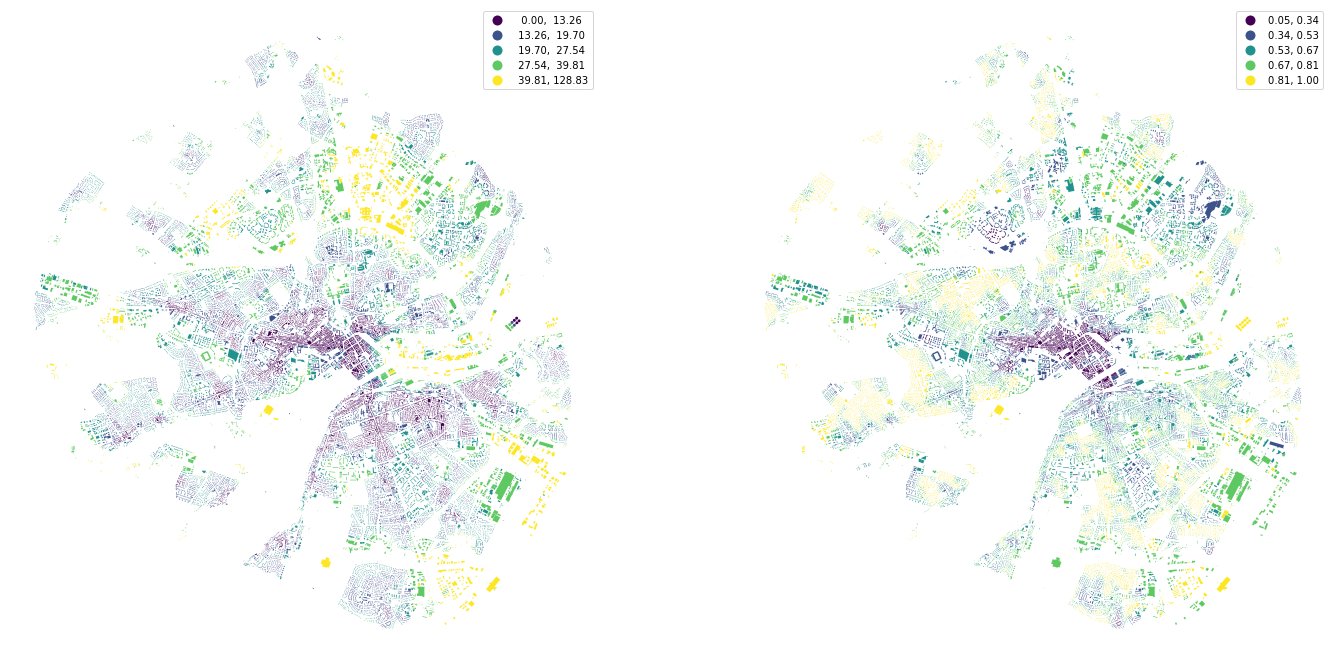

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [21]:
profile = mm.StreetProfile(streets, buildings)
streets["width"] = profile.w
streets["width_deviation"] = profile.wd
streets["openness"] = profile.o

c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\momepy\dimension.py:641: RuntimeWarning: invalid value encountered in long_scalars
  openness.append(np.isnan(s).sum() / (f).sum())


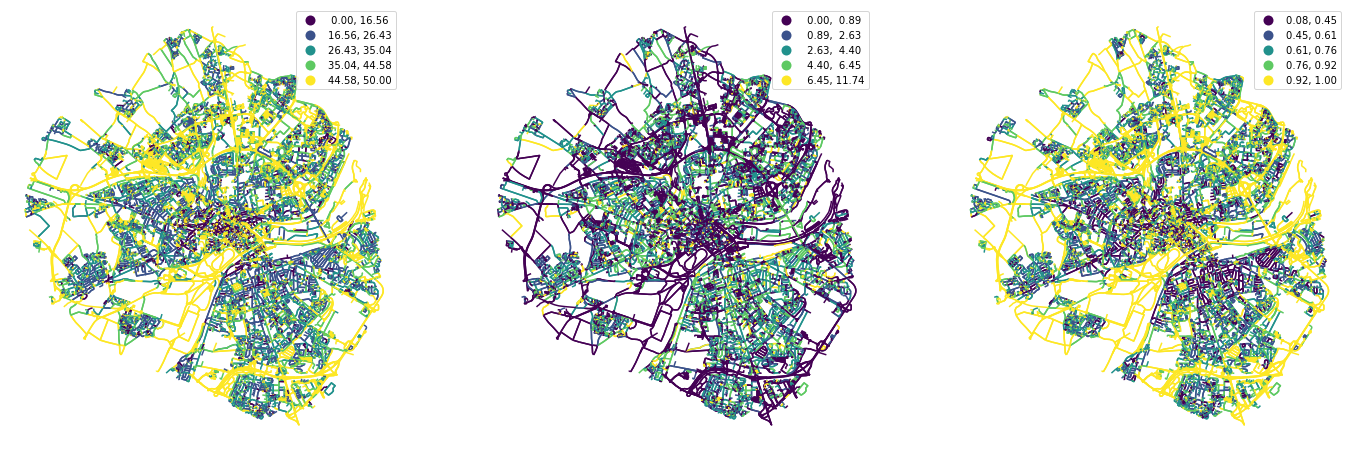

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

#### Intensity

In [23]:
tessellation['car'] = mm.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series

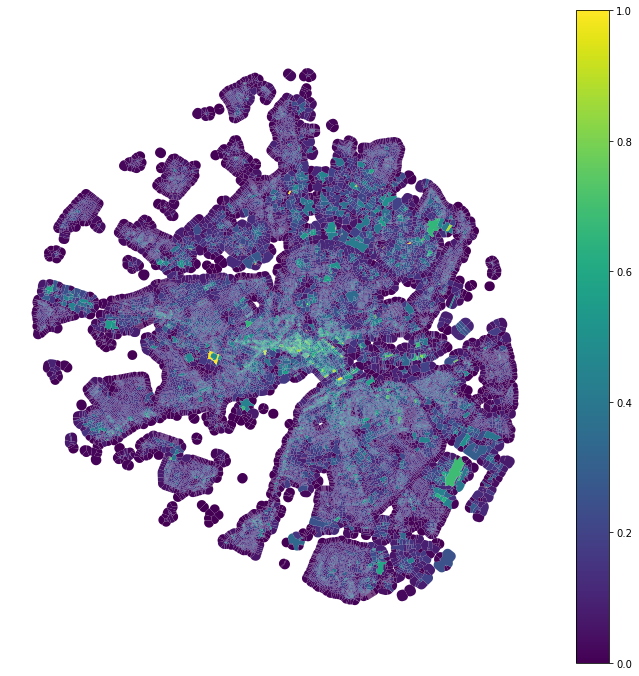

In [24]:

tessellation.plot("car", figsize=(12, 12), vmin=0, vmax=1, legend=True).set_axis_off()

#### Connectivity

In [25]:
graph = mm.gdf_to_nx(streets)

In [26]:
graph = mm.node_degree(graph)
graph = mm.closeness_centrality(graph, radius=400, distance="mm_len")
graph = mm.meshedness(graph, radius=400, distance="mm_len")

100%|██████████| 19563/19563 [05:00<00:00, 65.11it/s] 


In [27]:
nodes, streets = mm.nx_to_gdf(graph)

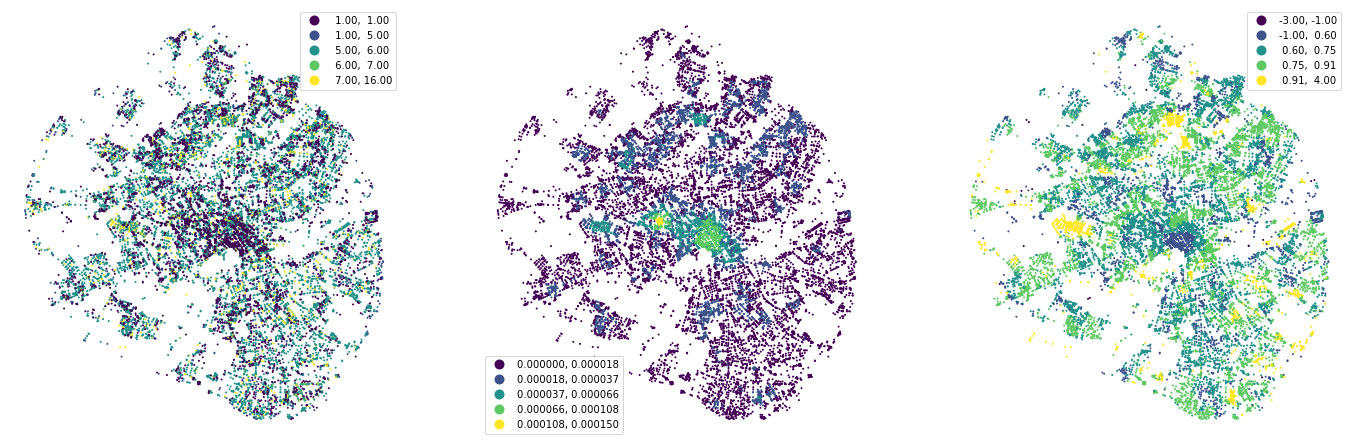

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot("degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1)
nodes.plot("closeness", ax=ax[1], scheme="natural_breaks", legend=True, markersize=1, legend_kwds={"fmt": "{:.6f}"})
nodes.plot("meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

In [29]:
buildings["nodeID"] = mm.get_node_id(buildings, nodes, streets, "nodeID", "nID")

100%|██████████| 53336/53336 [00:29<00:00, 1806.49it/s]


Merge all the data together

In [30]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'geometry']), on='uID')
merged = merged.merge(streets.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

### Understanding the context
Measure first, second and third quartile of distribution of values within an area around each building.

In [31]:
percentiles = []
for column in merged.columns.drop(["uID", "nodeID", "nID", 'mm_len', 'node_start', 'node_end', "geometry"]):
    perc = mm.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


In [32]:
percentiles_joined = pd.concat(percentiles, axis=1)

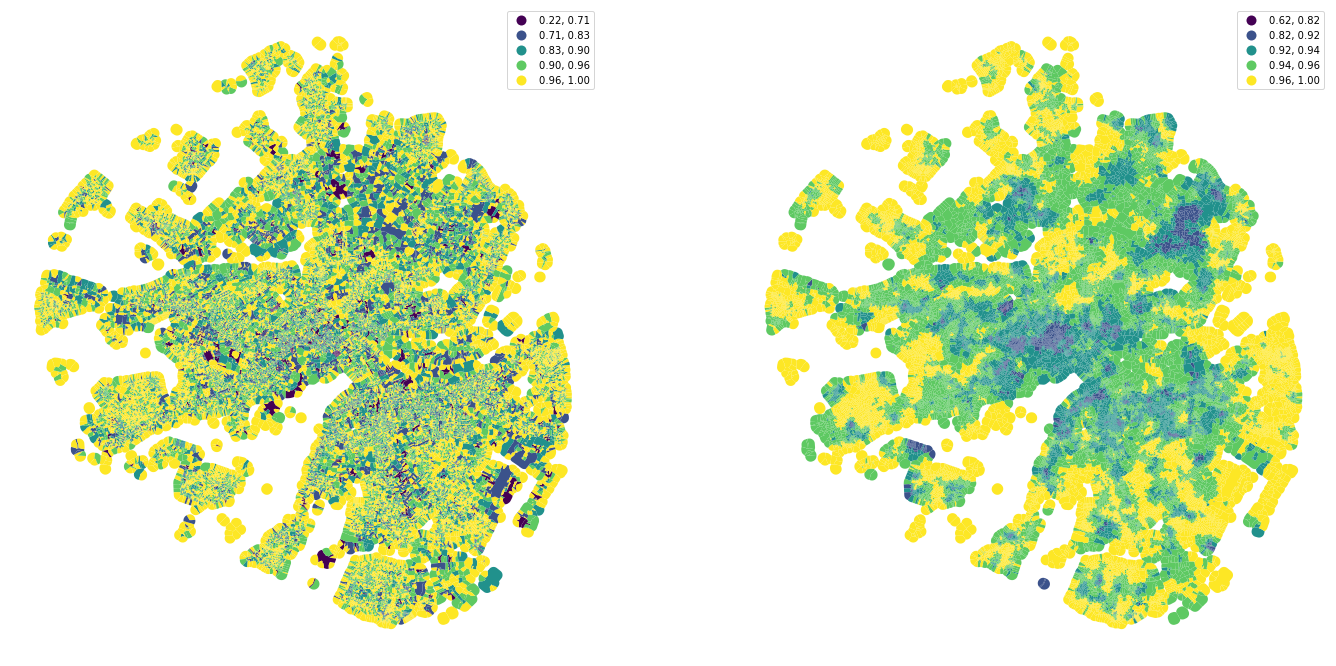

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
merged.plot(percentiles_joined['convexity_50'].values, ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

### Clustering

In [34]:
standardized = (percentiles_joined - percentiles_joined.mean()) / percentiles_joined.std()

#### How many clusters?

In [35]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=0)
cgram.fit(standardized.fillna(0))

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.5313234329223633 seconds.
K=3 fitted in 1.5707285404205322 seconds.
K=4 fitted in 0.8547186851501465 seconds.
K=5 fitted in 1.5747959613800049 seconds.
K=6 fitted in 1.5508599281311035 seconds.
K=7 fitted in 2.189948558807373 seconds.
K=8 fitted in 2.6668803691864014 seconds.
K=9 fitted in 3.5774500370025635 seconds.
K=10 fitted in 3.823145866394043 seconds.
K=11 fitted in 4.115084171295166 seconds.


In [36]:
show(cgram.bokeh())

In [37]:
cgram.labels.head()

1   2   3   4   5   6   7   8   9   10  11
0   0   0   0   1   3   5   2   7   7   3   8
1   0   0   0   1   3   5   2   7   7   3   8
2   0   0   0   1   3   5   2   7   7   3   8
3   0   0   0   1   3   5   2   7   7   3   8
4   0   0   0   1   3   5   2   7   7   3   8

In [38]:
merged["cluster"] = cgram.labels[8].values

In [39]:
urban_types = buildings[["geometry", "uID"]].merge(merged[["uID", "cluster"]], on="uID")

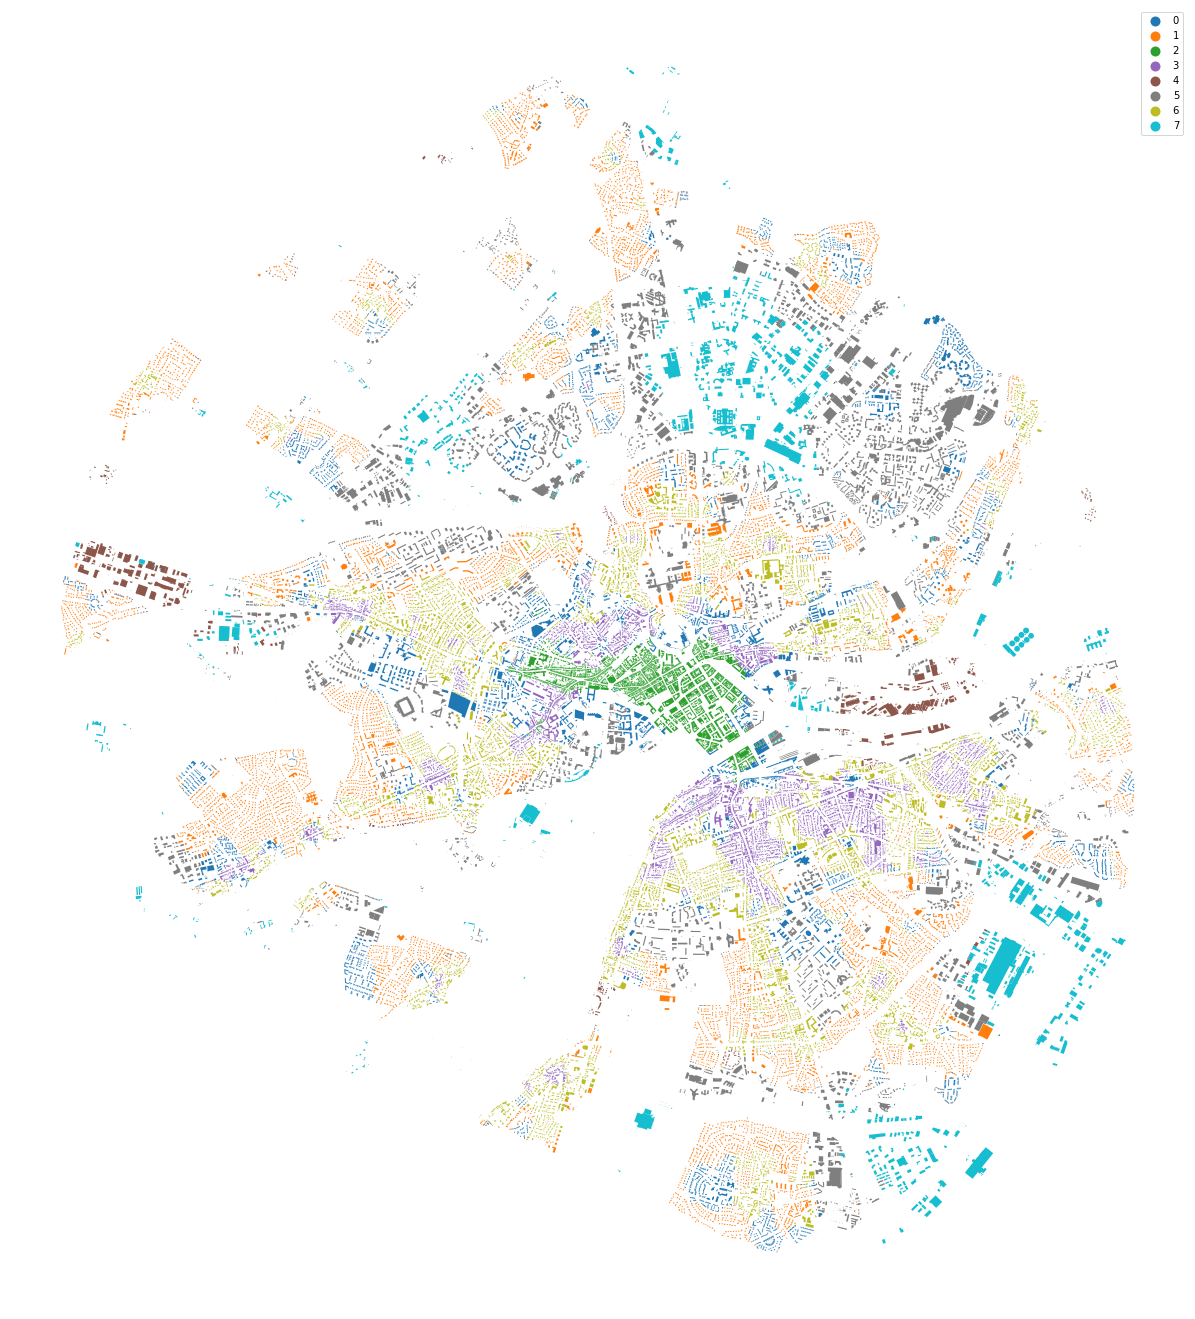

In [40]:
fig, ax = plt.subplots(1, figsize=(24, 24))

ax = urban_types.plot(column = 'cluster', ax=ax, categorical=True, legend=True)

ax.set_axis_off()

In [42]:
urban_types.to_parquet('./results/urban_types.parquet')